In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/international-airline-passengers/international-airline-passengers.csv


# RNN ile Havayolu Yolcu Sayısı Tahmini

Havayolu yolcu sayısı tahmini problemini çözmek için izlenecek adımlar.


1.  İş Problemi (Business Problem)
1.  Veriyi Anlamak (Data Understanding)
1.  Veriyi Hazırlamak (Data Preparation)
1.  Modelleme (Modeling)
1.  Değerlendirme (Evaluation)
1.  İş Problemi (Business Problem)

### 1) İş Problemi (Business Problem)
Veri setimiz 1949 yılından 1960 yılına olacak şekilde aylık olarak yolcu sayısını ifade etmektedir.
* Month: Aylık olarak yer alan tarih değişkenidir.
* Passengers: İlgili işlem tarihindeki yolcu sayısını, yani aylık yolcu sayısını temsil etmektedir.
* https://www.kaggle.com/andreazzini/international-airline-passengers

### 2) Veriyi Anlamak (Data Understanding)


##### 2.1) Gerekli Kütüphanelerin Import İşlemleri

In [2]:
# Veriyi okuma ve işleme adımında kullanılacak olan kütüphaneler
import numpy as np
import pandas as pd
import datetime as dt
import tensorflow as tf
import matplotlib.pyplot as plt

# Model değerlendirme ve veriyi scale edebilmemiz için kullanılacak olan kütüphaneler 
from sklearn.preprocessing import MinMaxScaler 
from sklearn.metrics import mean_squared_error

# Model için kullanılacak olan kütüphaneler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Warning'leri kapatmak için kullanılmaktadır. 
import warnings 
warnings.filterwarnings('ignore')

# Tensorflow Warning Engelleme 
import os 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


##### 2.2) Veri Setini Yüklenmesi ve Verinin Genel Resminin İncelenmesi

In [3]:
# Elimizdeki veri seti bir zaman serisi verisi.
df = pd.read_csv("/kaggle/input/international-airline-passengers/international-airline-passengers.csv")
df.head()

,Month,International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


In [4]:
# Değişken isimlerine erişme
df.columns

Index(['Month', 'International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60'], dtype='object')

In [5]:
df.columns = ["Month", "Passengers"]
df.head()

,Month,Passengers
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


In [6]:
df.tail()

,Month,Passengers
140,1960-09,508.0
141,1960-10,461.0
142,1960-11,390.0
143,1960-12,432.0
144,International airline passengers: monthly tota...,NaN


In [7]:
df.shape

(145, 2)

In [8]:
df.dtypes

Month          object
Passengers    float64
dtype: object

In [9]:
df.isnull().sum()

Month         0
Passengers    1
dtype: int64

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Passengers,144.0,280.298611,119.966317,104.0,180.0,265.5,360.5,622.0


### 3) Veriyi Hazırlamak

In [11]:
df = df[:144]  # Son satır sıkıntılı olduğu için attık
df.tail()

,Month,Passengers
139,1960-08,606.0
140,1960-09,508.0
141,1960-10,461.0
142,1960-11,390.0
143,1960-12,432.0


In [12]:
# Month aslında date değişkeni ama burda object diye görünüyor.
df["Month"] = pd.to_datetime(df["Month"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       144 non-null    datetime64[ns]
 1   Passengers  144 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.4 KB


In [13]:
print("Minimum Tarih :", df["Month"].min())
print("Maximum Tarih :", df["Month"].max())

Minimum Tarih : 1949-01-01 00:00:00
Maximum Tarih : 1960-12-01 00:00:00


2 değişkenimiz var. Burdaki ay değişkeni modele verilecek olan değil. Bu veri setindeki indeksimiz. Bunu indekse gönderelim:

In [14]:
df.index = df["Month"]
df.head()

,Month,Passengers
Month,,
1949-01-01,1949-01-01,112.0
1949-02-01,1949-02-01,118.0
1949-03-01,1949-03-01,132.0
1949-04-01,1949-04-01,129.0
1949-05-01,1949-05-01,121.0


In [15]:
# Month'u indekse gönderdikten sonra değişkenler arasından silmemiz lazım.
df.drop("Month", axis=1, inplace = True)
df.head()

,Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


In [16]:
result_df = df.copy()

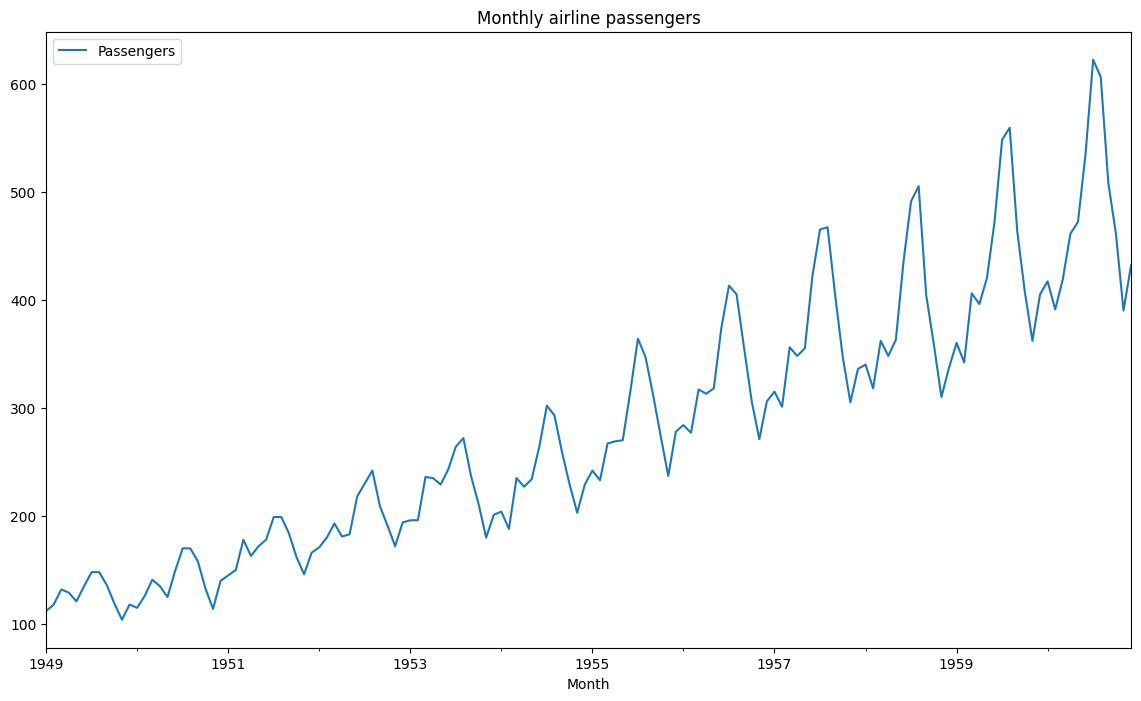

In [17]:
df.plot(figsize=(14, 8), title= 'Monthly airline passengers');

Şu anda veri pandas df formatında. Modelleme işlemine başlarken bu veriyi numpy arrayine çevirmemiz gerekir.

In [18]:
data = df["Passengers"].values
data[:5]      # data.head() --> head methodu df için kullanılabilen bir method.

array([112., 118., 132., 129., 121.])

In [19]:
print(type(data[:5]))
print(type(data[0]))

<class 'numpy.ndarray'>
<class 'numpy.float64'>


In [20]:
data = data.astype("float32")
type(data[0])

numpy.float32

In [21]:
data.shape   #Burda veriyi modele sokmak için 144'e 1 şeklinde bir dönüştürme yapmamız gerekiyor. 

(144,)

In [22]:
data = data.reshape(-1,1)
data.shape

(144, 1)

Burda veriyi train- test olarak ikiye ayıracağız. Zaman problemlerinde bu ayırma işlemleri rastgele değil örüntüyü kaybetmemek amacıyla daha dikkatli bir şekilde egerçekleştirilir.

In [23]:
def split_data(dataframe, test_size):
    position = int(round(len(dataframe) * (1 - test_size)))
    train = dataframe[:position]
    test = dataframe[position:]
    return train, test, position

In [24]:
train, test, position = split_data(data, 0.33)
print(train.shape, test.shape)

(96, 1) (48, 1)


In [25]:
# Minmaxscaler ile passengers sayısını 0-1 arasında dönüştürücez.
scaler_train = MinMaxScaler(feature_range=(0, 1))
train = scaler_train.fit_transform(train)

scaler_test = MinMaxScaler(feature_range=(0, 1))
test = scaler_test.fit_transform(test)

In [26]:
train[0:5]

array([[0.02588999],
       [0.04530746],
       [0.09061491],
       [0.08090615],
       [0.05501619]], dtype=float32)

In [27]:
test[0:5]

array([[0.04361373],
       [0.        ],
       [0.17133951],
       [0.1464175 ],
       [0.16822433]], dtype=float32)

Şimdi veri setimize yeni bir değişken ekliycez. Zaman serilerinde serinin T anındaki değeri en fazla kendisinden bir önceki zaman periyodundan etkileniyor. Yani pazartesinin yolcu sayısıyla ilgileniyorsak ya da satışlaryla ilgileniyorsak günlük periyoda sahip bir veri setinde pazartesinin fiyatını/ yolcu sayısını vs en fazla etkileyen değişken pazar günü değişkenidir. Bizim verimizdeki periyot ise 1 aylık. 1 aylık tahminler yaptığımızdan dolayı T anı en çok T-1'den etkileniyor olduğundan dolayı bir önceki ayın değerlerini bir feature olarak modele koymaya çalışıyor olacağız. 

In [28]:
def create_features(data, lookback):       #lookback şu kadar adım geriye bak demek
    X, Y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i - lookback:i, 0])
        Y.append(data[i, 0])
    return np.array(X), np.array(Y)

In [29]:
lookback = 1

# Train Veri Seti
X_train, y_train = create_features(train, lookback)

# Test Veri Seti
X_test, y_test = create_features(test, lookback)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(95, 1) (95,) (47, 1) (47,)


Öncesinde 96,1  ve 48,1 idi. Şİmdi 95 ve 47 olmasının sebebi 1 lookback yapmamız. Yani bir periyot gerisinden veriyi kaydırarak bir değişken oluşturma işlemi gerçekleştirdik. Bundan dolayı gözlem birimi sayıları train ve test setinde 1 tane eksik gibi gözüküyor.

## NOT/////////////////////////////////////////////////////////////////////////////////////////////////

In [30]:
#######################################################################################
#################BU FONKSİYONLA İLGİLİ NOT#############################################
def create_features(data, lookback):
    X, Y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i - lookback:i])
        Y.append(data[i])
    return np.array(X), np.array(Y)

import numpy as np

# Örnek zaman serisi
sample_data = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

lookback = 2
X_sample, y_sample = create_features(sample_data, lookback)

# Sonuçları görüntüle
print("X_sample:")
print(X_sample)

print("\ny_sample:")
print(y_sample)


X_sample:
[[1 2]
 [2 3]
 [3 4]
 [4 5]
 [5 6]
 [6 7]
 [7 8]
 [8 9]]

y_sample:
[ 3  4  5  6  7  8  9 10]


Burada her bir satır, X_sample'da bir özellik vektörünü temsil eder. Örneğin, ilk satır [1, 2] önceki iki zaman adımının değerlerini içerir ve bu vektörün karşılık gelen y_sample değeri 3'tür. Bu işlem, orijinal zaman serisi verisini kullanarak lookback kadar önceki değerlere dayalı özellikleri ve hedef çıktıları oluşturur.

In [31]:
# Örnek zaman serisi
sample_data = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

lookback = 1
X_sample, y_sample = create_features(sample_data, lookback)

# Sonuçları görüntüle
print("X_sample:")
print(X_sample)

print("\ny_sample:")
print(y_sample)

X_sample:
[[1]
 [2]
 [3]
 [4]
 [5]
 [6]
 [7]
 [8]
 [9]]

y_sample:
[ 2  3  4  5  6  7  8  9 10]


Lookback =1 olan versiyon. Her bir satır, X_sample'da bir özellik vektörünü temsil eder. Örneğin, ilk satır [1] önceki bir zaman adımının değerini içerir ve bu vektörün karşılık gelen y_sample değeri 2'dir. Bu işlem, orijinal zaman serisi verisini kullanarak bir önceki değere dayalı özellikleri ve hedef çıktıları oluşturur.

In [32]:
Diyelim ki elimizde şu veri seti var:
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

Ve lookback değerimizi 1 olarak belirledik. Bu durumda, her bir özellik vektörü (X) mevcut zaman adımından bir önceki 
zaman adımının değerini içerir, ve hedef çıktı (Y) mevcut zaman adımının değeridir.

İlk özellik vektörü ve hedef çıktı şu şekilde olurdu:
X_train: [1]
y_train: 2
    
İkinci özellik vektörü ve hedef çıktı:
X_train: [2]
y_train: 3
    
Ve bu şekilde devam eder. Ancak, ilk zaman adımında bir önceki zaman adımı olmadığı için ilk gözlem birimi eksik:
[1] -> [2] -> [3] -> ...    
Dolayısıyla, orijinal veri setindeki 10 gözlem birimi, lookback değeri nedeniyle 9 özellik vektörü ve hedef çıktı içerir.
Bir gözlem birimi kaybolduğu için de gözlem birimi sayısı 9'a düşer.

Bu durumda, X_train bir özellik vektörüdür ve içinde sadece bir eleman barındırır. Bu eleman, mevcut zaman adımından bir 
önceki zaman adımının değerini temsil eder. y_train ise karşılık gelen hedef çıktıdır ve bu, mevcut zaman adımının değerini
temsil eder.

Örneğin, X_train: [1] ve y_train: 2 ifadesi şu anlama gelir: Modelin eğitimi sırasında, modele bir örnek verildiğinde,
            modelin giriş olarak [1] özellik vektörünü alıp, hedef çıktı olarak da 2'yi tahmin etmesi beklenir.

Bu, aslında bir zaman serisi verisi üzerinde bir önceki zaman adımının değerine dayalı olarak bir sonraki zaman adımının
tahmin edilmesine yönelik bir örnek oluşturma yöntemidir. Yani, model, bir zaman serisindeki desenleri öğrenerek,
mevcut zaman adımındaki değeri bir önceki zaman adımının değerine dayanarak tahmin etmeye çalışır.

SyntaxError: unterminated string literal (detected at line 18) (3066125399.py, line 18)

## ////////////////////////////////////////////////////////////////////////////////////////////////

Yeniden ölçeklendirme ve feature ekleme işlemlerimiz tamamlandı. Şimdi ise veri setimizi yeniden şekillendirerek 3 boyutlu bir hale getirmemiz gerekiyor olacak. Yani sinir ağına göndermeden önce veri setini RNN'nin istediği formata getirmemiz gerekmektedir. Bunu reshape metoduyla gerçekleştiriyoruz.

In [ ]:
# RNN'e gönderilecek verinin 3 boyutlu bir yapıda olması gerekir.
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

Bu RNN'nin bizden istediği format. Bundan dolayı veriyi tek değişken varsa dahi bir boyut ekleyerek aslında 2 boyuta çıkardık. Eğer 2 değişken varsa veya daha fazla sayıda değişken varsa bunu 3 boyutlu bir formata getirdik. 

## 4) Modelleme (Modeling)

In [ ]:
model = Sequential()   # SimpleRNN --> Kuracağımız sinir ağının ismi.
model.add(SimpleRNN(units=50, activation='relu', input_shape=(X_train.shape[1], lookback)))  # RNN'deki bu nöronlar birbirinden tamamen bağımsız değil. Birbirleriyle iletişim kurarak geçmişteki bilgiyi birbirlerine transfer edebilirler.
model.add(Dropout(0.2))        # Sinir ağının overfit etmesini önlemek için. Her iterasyonda %2 rastgele nöronların söndürülerek aşırı öğrenmenin önüne geçilmesini bekliyoruz.
model.add(Dense(1))     # Çıkış katmanımız. Bunda da 1 tane nöron var. 1 tane çıktımız var. Neden? Çünkü burda çıktıdan beklediğimiz değer bir sınıf değeri değil regresyon benzeri bir sayısal tahmin değeri.

model.summary()

Modelin dış cephesini tamamladık yani mimarisini. Şimdi iç kısmına geçiyoruz.

Patience = Eğitimin durdurulacağı iyileşme olmayan dönemin sayısı. Yani 2, 3, 5 iterasyon sonucunda validasyon lossunda ilerleme yoksa artık dur demenin yolu.

Verbose = İşlemin raporlanma şekli.

Mode = Modelin gelişimini takip etmekle ilgili bir parametre. Min modunda izlediğimiz miktarın azalması durduğunda eğitim durur.  Yani burdali val_loss'da azalma durursa eğitim durur anlamına gelir. Max modunda ise izlenen miktarın artması durduğunda eğitim durur. 

ModelCheckpoint kullanma sebebimiz modeli kaydetme görevleriyle ilgilidir. İstersek en iyi istersek diğer modelleride kaydedebiliriz. İstersek en iyi modelle birlikte sadece modelin ağırlıklarını da kaydedebiliriz.


Modelin optimizasyon metriklerinin belirlenmesi işlemi compile() fonksiyonu tarafından gerçekleştirilir.

Bu fonksiyon, modelin derlenmesi (compile) aşamasında kullanılan kayıp fonksiyonunu, optimizasyon algoritmasını ve isteğe bağlı olarak takip edilecek metrikleri belirlemenizi sağlar.

In [ ]:
from tensorflow.keras.optimizers import Adam

# Optimizasyon ve Değerlendirme Metrikleri Ayarlanması
# Modelin derlenmesi
model.compile(loss='mean_squared_error', optimizer=Adam()) # loss fonku olarak mse kullandık. Bu mse loss fonksiyonunu optimize etmek için adam yöntemini kullan dedik. 

# Geri çağrıların ayarlanması
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode="min"),   # aşırı öğrenmeye karşı kontrolü sağlamak için. Train ve validasyon setleri arasındaki değişimlere odaklanarak modelin aşırı öğrenmeye gitmesini engellemek için kullanılır. Normalde belirli bir noktaya kadar train ve test(validasyon) setinde loss beraber düşerken belirli bir noktadan sonra train setinde loss düşmeye devam ederken test setinde düşmeyi keser. Dolayısıyla earlystopping Validasyon lossunda düşme olmadığında dur der. 
    ModelCheckpoint(filepath='mymodel.h5', monitor='val_loss', mode='min', save_best_only=True, save_weights_only=False, verbose=1)  # model çalışmayı sürdürürken modeli kaydetme ayarlaması
]

# Bütün işlemleri gerçekleştirdik artık sıra modeli fit etmekte.

# Modelin eğitimi
history = model.fit(     # modelin sonuçlarını history'de tutuyoruz.
    x=X_train,
    y=y_train,
    epochs=50,
    batch_size=1,    #veri gruplarının boyutu
    validation_data=(X_test, y_test),
    callbacks=callbacks,
    shuffle=False     # optimizasyon işlemi sırasında shuffle etme(karıştırma) dedik. 
)

Validasyon lossunda artık bir ilerleme gözlemlenmeyince 9. epochta durdu. Eğer durdurmasaydık, yani 50 epochu tamamlasaydı bu sefer bütün veri setini ezberleyecekt ve görmediği verilerdeki başarı performansı kötü olacaktı. 

Modelimizin loss grafriğini oluşturalım. (Epoch sayısına karşılık lossumuz ne)

In [ ]:
plt.figure(figsize=(20, 5))

# Training and Validation Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.ylim([0, max(plt.ylim())])
plt.title('Training and Validation Loss', fontsize=16)

plt.show()

## 5) Değerlendirme(Evaluation)
Modelimizin tahmin etme başarısını daha anlaşılır bir açıdan ele alıcaz.

In [ ]:
# Evaluate the model on the test set
loss = model.evaluate(X_test, y_test, batch_size=1)  

# Print the test loss as a percentage
print("\nTest loss: %.1f%%" % (100.0 * loss))# Best modelin sonucu


Burdaki loss ifadesi MSE değeri. Yani MSE'nin 0.02 geldiğini gözlemliyoruz. Yüzdeliği de %2.3. Bu ne anlama geliyor? Biz bu modeli kullanırken bir tahmin etme işlemi yaptığımızda yapabileceğimiz ortalama hatayı ifade ediyor. Yani gelecek periyotlarla ilgili mesela passengers sayısıyla ilgili örneğin 100 ise tahmin etme işlemimiz 100,2 gibi bir hatayla tahmin etmiş olucaz. Ama bu çok yüksek bir başarı. Yani bu gerçekten bizim hatamız mı? Dediğimizde aslında biz değişkenleri 0-1 arasında standartlaştırmıştık. Dolayısıyla kurmuş olduğumuz model ve elde ettiğimiz hatalara odaklandığımız loss fonkunun sonucu MSE olsa da standartlaştırılmış değerler üzerinden bir hata metriğidir. Dolayısıla burda modelimizi kullanarak train ve test seti için tahmin etme işlemleri yapıp hatalarımızı inversetransform diyerek daha doğru bir şekilde değerlendiriyor olucaz.

In [ ]:
# Tahminleri al ve normalize edilmiş hallerinden geri dönüştür
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)


# Modelleme öncesinde yapmış olduğumuz 0-1 arasında standartlaştırma işlemini scaler_train ve test içerisinden geriye çeviriyoruz.
# Inverse transform bu değerleri geriye çeviriyor. Bu şekilde sağlıklı bir kıyaslama yapıyoruz.
train_predict = scaler_train.inverse_transform(train_predict)
test_predict = scaler_test.inverse_transform(test_predict)

# Geri alma işlemini train ve testin gerçek değerleri içinde yapmamız gerekiyor.
# Gerçek değerleri normalize edilmiş hallerinden geri dönüştür
y_train_denormalized = scaler_train.inverse_transform(y_train)
y_test_denormalized = scaler_test.inverse_transform(y_test)

# Train veri setine ait RMSE değeri
train_rmse = np.sqrt(mean_squared_error(y_train_denormalized, train_predict))

# Test veri setine ait RMSE değeri
test_rmse = np.sqrt(mean_squared_error(y_test_denormalized, test_predict))

print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")


Train hatası 25 birim, test hatası 48 birim. Bu tahminlerde ne kadar başarılıyım? İyi miyim sorusunun cevabı da:

In [ ]:
df.describe().T

Burdaki 280 yıllara göre ortalama yolcu sayısı. Test hatamızı 48 bulduk. Yani çok iyi değil ama çok kötü de değil. Yani örneğin biz bir yılda 300 yolcu alacakken gerçekte, tahminimiz sonucunda 348 veya 252 diyebiliriz. 

Yani bu model aracılığıyla bir tahminde bulunduğumuzda elde edecek olduğumuz sonuçlarda 46 birimlik bir sapma ile bu tahminleri gerçekeştirebilriz. 

Şimdi tahminlerin ve gerçek değerlerin görselleştirilmesi işlemini değerlendirelim. Burda train veri setine ilişkin günlük tahminlerin alınması ve gerçek değerlerle kıytaslanması işlemini gerçekleştiricez. Burada dikkat edilmesi gereken nokta train veri setindeki ilk gözlemin kendinden önceki bir gözleme sahip olmaması. Yani 1949 02 01 tarihinde bu tarihten daha önce bir yoldu yok. Bunu konuşmamızın sebebi lookback yaparak 1 periyot geriye gidiyorduk. Bu 1 periyot geriye gittiğimiz seneryoda  1949 03 01 tarihinin bir öncesi var 1949 04 01'in öncesi var ama 1949 02 01 tarihinin öncesinde bir değer yok.

In [ ]:
train_prediction_df = result_df[lookback:position] #result_df--> Veri setimizin ilk hali. Yani burda ilk halinden bir 
# seçme işlemi yapıyor olucaz. Lookbakc 1 idi. 1 gözlemi pas geçicez çünkü bir öncesi yoktu.

train_prediction_df["Predicted"] = train_predict

train_prediction_df.head()

Burda her bir zaman periyodu için her bir ay için tahminlerde bulunduk. İlk ayda mesela normalde 118 iken biz 133 demişiz.

Bu işlemin bir benzerini test seti için de gerçekleştirelim.

In [ ]:
test_prediction_df = result_df[position+lookback:] 

test_prediction_df["Predicted"] = test_predict

test_prediction_df.head()

position = 100  # Örnek bir başlangıç pozisyonu

lookback = 20   # Başlangıç pozisyonundan itibaren 20 adet veriyi seç

test_prediction_df = result_df[position+lookback:]

Bu durumda, test_prediction_df, result_df veri çerçevesindeki 120. pozisyondan başlayarak sonraki verileri içerecektir.

test_prediction_df = result_df[position+lookback:]: Bu satır, belirli bir position değerinden (position+lookback) başlayarak sonraki tüm verileri içerir. Bu, genellikle test verilerini veya tahminlerini içerir.


train_prediction_df = result_df[lookback:position]: Bu satır, belirli bir lookback değerinden başlayarak belirli bir position değerine kadar olan verileri içerir. Bu, genellikle eğitim verilerini içerir.

lookback = 20    # Başlangıç pozisyonundan itibaren 20 adet veriyi seç

position = 100   # Belirli bir pozisyona kadar olan verileri seç

train_prediction_df = result_df[lookback:position]

Bu durumda, train_prediction_df, result_df veri çerçevesindeki 21. pozisyondan başlayarak 100. pozisyona kadar olan verileri içerecektir.

In [ ]:
# Train ve Test Tahminlerini ayrı ayrı görselleştirme işlemi
plt.figure(figsize=(14, 5))
plt.plot(result_df, label='Real Number of Passengers')
plt.plot(train_prediction_df["Predicted"], color='blue', label='Train Predicted Number of Passengers')
plt.plot(test_prediction_df["Predicted"], color="red", label='Test Predicted Number of Passengers')
plt.title('Number of Passengers Prediction')
plt.xlabel('Time')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

Burda açık maviler gerçek değerler. Koyu maviler train setine ilişkin tahmin ettiğimiz değerler. Kırmızı değerler ise test setine ilişkin tahmin ettiğimiz değerler.

### NOTLAR

**Data Leakage (Veri Sızıntısı):**

Diyelim ki bir modeliniz var ve bu model bir evin fiyatını tahmin etmek için eğitiliyor. Eğitim veri setinizde ev fiyatları ile ilgili bilgiler var: metrekare, oda sayısı, konum gibi özellikler.

Eğitim aşamasında, bu veri setini kullanarak modelinizi eğitiyorsunuz. Ancak, bir hata yapıyorsunuz ve tüm veri setini kullanarak ev fiyatlarındaki ortalama değeri ve standart sapmayı hesaplayarak veriyi normalize ediyorsunuz. Normalizasyon, özellik değerlerini belirli bir aralığa veya dağılıma getirme işlemidir.

Bu durumda, bu normalizasyon işlemi eğitim verilerini dönüştürmek için kullanıldığından, ev fiyatlarındaki ortalamayı ve standart sapmayı bilmek modelinize gelecekteki ev fiyatlarını tahmin etmede yardımcı olacaktır. Bu durumda, eğitim veri setinin bir kısmı aslında gelecekteki tahmin işlemi için "sızdırılmış" bir bilgi içerir.

Eğitim veri setini kullanarak elde edilen normalizasyon parametrelerini (ortalama ve standart sapma gibi) doğrudan test veri setine uygularsanız, bu, modelin aslında gelecekteki verileri gördüğü ve bu verileri öğrendiği anlamına gelir. Bu durumda, modelin gerçek dünya performansını değerlendirmek zor olacaktır, çünkü model aslında gelecekteki verileri önceden biliyor gibi davranacaktır.

Bu nedenle, normalizasyon parametrelerini hesaplamak için kullanılan istatistikleri eğitim ve test aşamalarında ayrı ayrı hesaplamak önemlidir. Eğitim veri seti üzerinde bu istatistikleri hesaplayıp, bu istatistikleri kullanarak normalize ediyorsanız, test veri setini aynı istatistiklerle normalize etmekten kaçınmalısınız. Aksi halde, veri sızıntısı gerçekleşir.

**Gradient Descent (Gradyan İniş):** Gradient Descent, bir fonksiyonun minimum veya maksimum noktasını bulmada kullanılan bir optimizasyon algoritmasıdır. Yapay sinir ağlarında, modelin kayıp fonksiyonunu minimize etmek için kullanılır. Ağırlıkları güncellemek için, kayıp fonksiyonunun gradyanını (türevini) kullanarak belirli bir öğrenme oranıyla (learning rate) ağırlıkları günceller.

**En Küçük Kareler Yöntemi (Least Squares Method):** En Küçük Kareler Yöntemi, regresyon analizi gibi problemlerde kullanılan bir optimizasyon yöntemidir. Yapay sinir ağları bağlamında, genellikle regresyon problemlerinde kullanılan bir kayıp fonksiyonu ile ilişkilidir.

**İleriye Yayılım (Backpropagation):** İleriye Yayılım, yapay sinir ağlarının eğitilmesinde kullanılan bir algoritmadır. Bu algoritma, ağın çıkışındaki tahminlerin gerçek değerlerden ne kadar uzak olduğunu ölçen bir kayıp fonksiyonunu minimize etmeye çalışır. İleri yayılım, Gradient Descent'in bir türüdür ve ağırlıkları güncellemek için zincir kuralını kullanır.

**Öz Yinelemeli Sinir Ağları**

Bu tür sinir ağları, zaman serisi veya dizisel verilerle çalışmak üzere tasarlanmıştır. RNN'ler (Recurrent Neural Networks), önceki adımlardan gelen bilgileri içererek giriş verileri üzerinde işlem yapabilir ve bu özellikleri zaman içindeki bağımlılıkları modelleme açısından güçlü kılar. Bu nedenle özellikle sıralı veri türlerinde kullanılırlar.

**reshape(-1,1) Nedir? Örnekle açıklaması.**

In [ ]:
import numpy as np

# Örnek veri oluşturalım
data = np.array([1, 2, 3, 4, 5, 6])

# Veriyi yeniden şekillendirelim
reshaped_data = data.reshape(-1, 1)

print("Orijinal Veri:")
print(data)
print("Yeniden Şekillendirilmiş Veri:")
print(reshaped_data)

Bu kod örneğinde, orijinal veri bir vektördür ve reshape(-1, 1) ifadesi ile bu vektör bir sütun matrisine dönüştürülür. -1 ifadesi, boyutun belirlenmemiş olduğunu ifade eder ve bu boyut, orijinal veri boyutuna göre otomatik olarak hesaplanır. Yani, orijinal verideki eleman sayısı kadar satır, 1 sütunlu bir matris oluşturulur.

Bu işlem, özellikle bir makine öğrenimi modeline veri beslerken veya bazı matematiksel işlemler yaparken giriş verilerini belirli bir formata getirmek için kullanılır.